<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeles" data-toc-modified-id="Modeles-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeles</a></span></li><li><span><a href="#Sinus" data-toc-modified-id="Sinus-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sinus</a></span></li><li><span><a href="#Sinus-avec-tendence-linéaire-et-bruit" data-toc-modified-id="Sinus-avec-tendence-linéaire-et-bruit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sinus avec tendence linéaire et bruit</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#RNN-simple" data-toc-modified-id="RNN-simple-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>RNN simple</a></span></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>LSTM</a></span></li><li><span><a href="#GRU" data-toc-modified-id="GRU-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>GRU</a></span></li></ul></li><li><span><a href="#Scores-TimeSeriesSplit" data-toc-modified-id="Scores-TimeSeriesSplit-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Scores TimeSeriesSplit</a></span><ul class="toc-item"><li><span><a href="#RNN-simple" data-toc-modified-id="RNN-simple-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>RNN simple</a></span></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>LSTM</a></span></li><li><span><a href="#GRU" data-toc-modified-id="GRU-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>GRU</a></span></li></ul></li><li><span><a href="#Temperatures-globales" data-toc-modified-id="Temperatures-globales-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Temperatures globales</a></span><ul class="toc-item"><li><span><a href="#LSTM" data-toc-modified-id="LSTM-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>LSTM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>XGBoost</a></span><ul class="toc-item"><li><span><a href="#manual-loop" data-toc-modified-id="manual-loop-3.2.2.1"><span class="toc-item-num">3.2.2.1&nbsp;&nbsp;</span>manual loop</a></span></li><li><span><a href="#TimeseriesGenerator" data-toc-modified-id="TimeseriesGenerator-3.2.2.2"><span class="toc-item-num">3.2.2.2&nbsp;&nbsp;</span>TimeseriesGenerator</a></span></li></ul></li><li><span><a href="#Conv-1-D" data-toc-modified-id="Conv-1-D-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Conv 1-D</a></span></li></ul></li></ul></li></ul></div>

In [60]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import pandas as pd

# Modeles

In [109]:
from tensorflow.keras import Input
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Input, Dense, LeakyReLU
from tensorflow.keras.losses import mse

def rnn_model(units=10, input_length=1, cell_type=SimpleRNN):
    model = Sequential()
    model.add(Input(shape=(input_length,1)))
    model.add(cell_type(units, activation=LeakyReLU(alpha=0.3)))
    model.add(Dense(1))
    return model

# Sinus

In [19]:
size=1000
x=np.arange(size)
def signal(A=0, f=1, p=0, a=0, b=0, n=0, s_bias=1, n_bias=1, mult=False):
    sine = A*np.sin(2*f*x*np.pi+p) #+ A*np.cos(2*f/2*x*np.pi+p)
    linear = a * x + b
    noise = n*np.random.normal(size=x.shape)
    if mult:
        return lambda x: linear*(sine+s_bias)*(noise+n_bias)
    return lambda x: linear+sine+noise



In [4]:
s = signal(A=1, f=(1/50))(x)

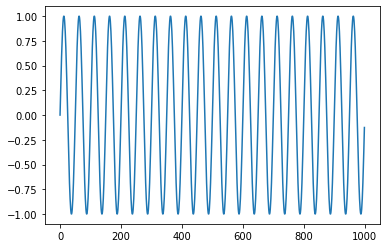

In [5]:
plt.plot(s)

In [6]:
#input_size = 10
X = s[0:-1].reshape(-1,1,1)
y = s[1:]

In [7]:
X.shape

(999, 1, 1)

In [47]:
INPUT_LENGTH = 5
EPOCH = 5
s = s.reshape(-1,1)
train_size = 900
X_train, X_test = s[:train_size], s[train_size-INPUT_LENGTH:]
train_generator = TimeseriesGenerator(X_train, X_train, length=INPUT_LENGTH, batch_size=10)
test_generator = TimeseriesGenerator(X_test, X_test, length=INPUT_LENGTH, batch_size=10)
# X = []
# y = []
# for i in range(len(s)-INPUT_LENGTH):
#     X.append(s[i:i+INPUT_LENGTH])
#     y.append(s[i+INPUT_LENGTH])
# X = np.array(X).reshape(-1,INPUT_LENGTH,1)
# y = np.array(y)
    
simple = rnn_model(units=10, input_length=INPUT_LENGTH, cell_type=SimpleRNN)
simple.compile(optimizer='adam', loss=mse)
simple.summary()
#simple.fit(X, y, batch_size=64, epochs=20, verbose=0)
simple.fit_generator(train_generator, epochs=EPOCH, verbose=0)
#pred = simple.predict(X)
score = simple.evaluate_generator(test_generator)
print(score)
trainPredict = simple.predict_generator(train_generator)
testPredict = simple.predict_generator(test_generator)

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_23 (SimpleRNN)    (None, 10)                120       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
0.0009677401627413929


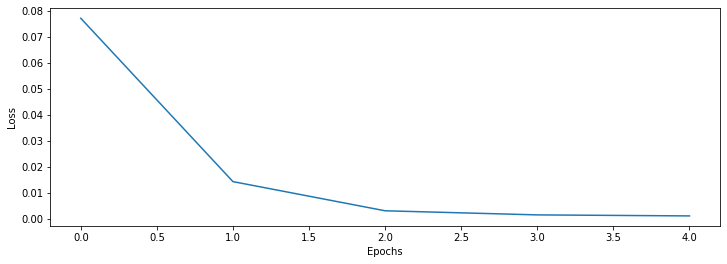

In [48]:
losses = simple.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses)),losses);

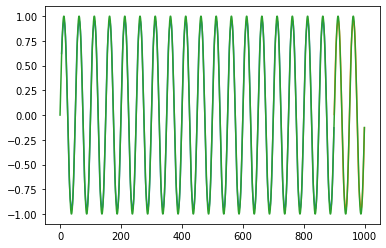

In [49]:
#%matplotlib inline
plt.plot(np.arange(trainPredict.shape[0])+INPUT_LENGTH, trainPredict)
plt.plot(range(train_size, s.shape[0]) ,testPredict)
plt.plot(s)
plt.show()

# Sinus avec tendence linéaire et bruit

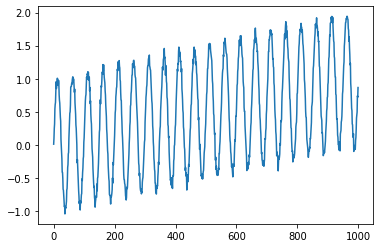

In [20]:
size=1000
x=np.arange(size)
s2 = signal(A=1, f=1/50, a=0.001, n=0.05)(x)
s2 = s2.reshape(-1,1)
# X = []
# y = []
# for i in range(len(s)-INPUT_LENGTH):
#     X.append(s2[i:i+INPUT_LENGTH])
#     y.append(s2[i+INPUT_LENGTH])
# X = np.array(X).reshape(-1,INPUT_LENGTH,1)
# y = np.array(y)

plt.plot(s2);

In [110]:
#from time import time
INPUT_LENGTH = 10
EPOCH = 5
def plot_pred(series, train_size, model, input_length=INPUT_LENGTH, batch_size=10):
    #train_size = 900
    X_train, X_test = series[:train_size], series[train_size-input_length:]
    train_generator = TimeseriesGenerator(X_train, X_train, length=input_length, batch_size=batch_size)
    test_generator = TimeseriesGenerator(X_test, X_test, length=input_length, batch_size=batch_size)
 
    #model = rnn_model(units=units, input_length=input_length, cell_type=SimpleRNN)

    model.compile(optimizer='adam', loss=mse)

    #start = time()
    model.fit_generator(train_generator, epochs=EPOCH, verbose=0)
    #print(f"fit: {time()-start} s")
    
    
    score = model.evaluate_generator(test_generator)
    print(score)
    
    #start = time()
    trainPredict = model.predict_generator(train_generator)
    #print(f"predict train: {time()-start} s")
    #start = time()
    testPredict = model.predict_generator(test_generator)
    #print(f"predict test: {time()-start} s")
    
    plt.figure(figsize=(12,6))
    losses = model.history.history['loss']
    plt.subplot(2,1,1)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(range(len(losses)),losses)
    
    plt.subplot(2,1,2)
    plt.plot(series)
    plt.plot(np.arange(trainPredict.shape[0])+input_length, trainPredict)
    plt.plot(range(train_size, train_size+testPredict.shape[0]) ,testPredict)

### RNN simple

0.03951639952138066


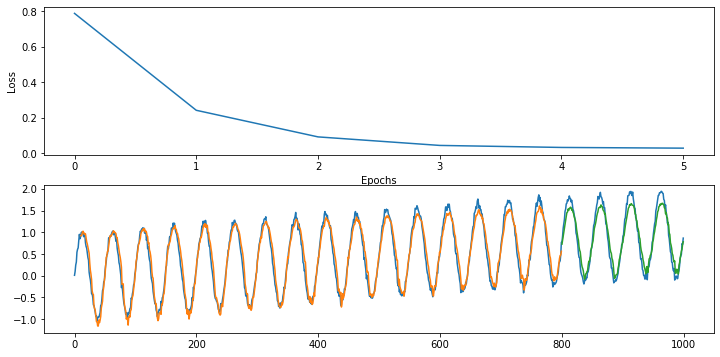

In [115]:
EPOCH = 6
plot_pred(s2, train_size=800, input_length=INPUT_LENGTH,
          model=rnn_model(units=10, input_length=INPUT_LENGTH, cell_type=SimpleRNN)
         )

### LSTM

0.009533763516810723


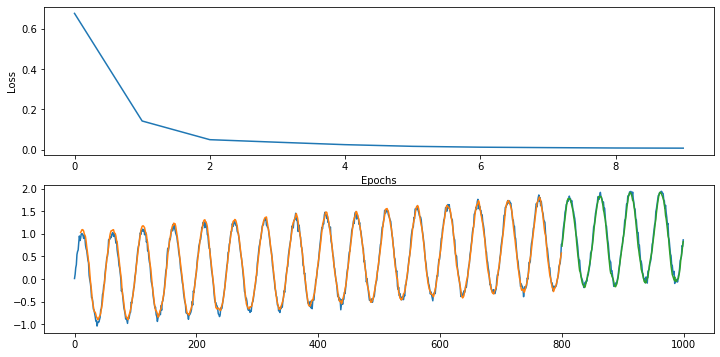

In [114]:
EPOCH = 10
plot_pred(s2, train_size=800, input_length=INPUT_LENGTH, batch_size=5,
          model=rnn_model(units=10, input_length=INPUT_LENGTH, cell_type=LSTM)
         )

### GRU

0.008266891277162357


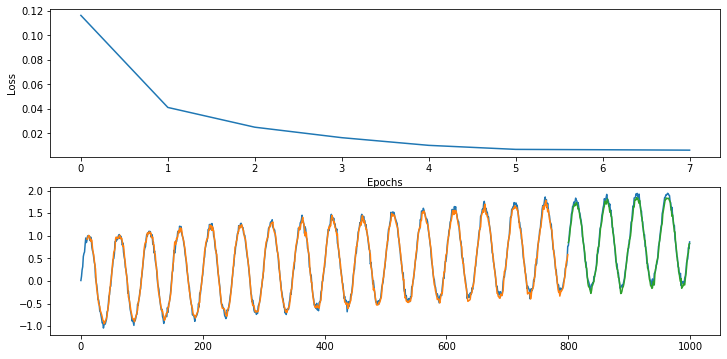

In [113]:
plot_pred(s2, train_size=800, input_length=INPUT_LENGTH, batch_size=5,
          model=rnn_model(units=10, input_length=INPUT_LENGTH, cell_type=GRU)
         )

## Scores TimeSeriesSplit

In [20]:
def score(series, model_type=SimpleRNN):
    scores = [] 
    splits = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in splits.split(X):
        X_train, X_test = series[train_index], series[test_index-INPUT_LENGTH]
        train_generator = TimeseriesGenerator(X_train, X_train, length=INPUT_LENGTH, batch_size=10)
        test_generator = TimeseriesGenerator(X_test, X_test, length=INPUT_LENGTH, batch_size=10)
    
        model = rnn_model(input_length=INPUT_LENGTH, cell_type=model_type)
        model.compile(optimizer='nadam', loss=mse)
    
        model.fit_generator(train_generator, epochs=EPOCH, verbose=0)
    
        scores.append(model.evaluate_generator(test_generator))
    return scores

### RNN simple

In [24]:
rnn_scores = score(s2, SimpleRNN)
print(rnn_scores)

[0.5548876857056337, 0.21513847250710516, 0.20308424828245358, 0.026436921866501078, 0.2529426588512519]


### LSTM

In [25]:
lstm_scores = score(s2, LSTM)
print(lstm_scores)

[0.5178221271318548, 0.2789988573640585, 0.49350621573188724, 0.4989350464414148, 0.12678219416343114]


### GRU

In [26]:
gru_scores = score(s2, GRU)
print(gru_scores)

[0.40946455738123727, 0.43032018215778994, 0.07583773875718608, 0.6291417860809494, 0.0812789847909966]


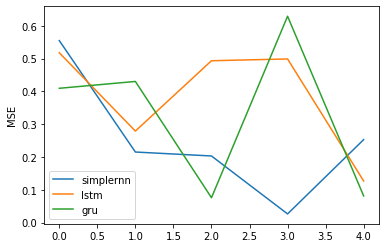

In [27]:
plt.plot(rnn_scores, label='simplernn')
plt.plot(lstm_scores, label='lstm')
plt.plot(gru_scores, label='gru')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Temperatures globales
https://data.world/data-society/global-climate-change-data/workspace/file?filename=GlobalLandTemperatures%2FGlobalTemperatures.csv

In [32]:
temp = pd.read_csv("GlobalLandTemperatures_GlobalTemperatures.csv")
temp["dt"] = temp["dt"].apply(lambda x: np.datetime64(x))
temp = temp[['dt','LandAverageTemperature']]
temp = temp.iloc[-500:]

### LSTM

0.1804623459931463


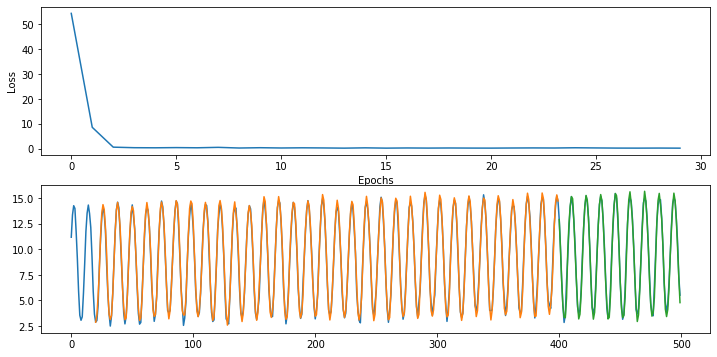

In [116]:
EPOCH = 30
plot_pred(temp['LandAverageTemperature'].values.reshape(-1,1),
          train_size=400, input_length=20, batch_size=5,
          model=rnn_model(units=30, input_length=20, cell_type=LSTM)
         )

### XGBoost

In [36]:
from xgboost import XGBRegressor

In [215]:
INPUT_LENGTH = 20
TRAINING_SIZE = 400

series = temp['LandAverageTemperature'].values

#### manual loop

In [222]:
X = []
y = []
for i in range(series.shape[0]-INPUT_LENGTH):
    X.append(series[i:i+INPUT_LENGTH])
    y.append(series[i+INPUT_LENGTH])
X = np.array(X).reshape(-1,INPUT_LENGTH)
y = np.array(y)

train_size = TRAINING_SIZE-INPUT_LENGTH
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [223]:
reg = XGBRegressor(seed=42)
reg.fit(X_train, y_train)

testPredict = reg.predict(X_test)
trainPredict = reg.predict(X_train)
print(float(mse(y_train, trainPredict)))

0.041728194802999496


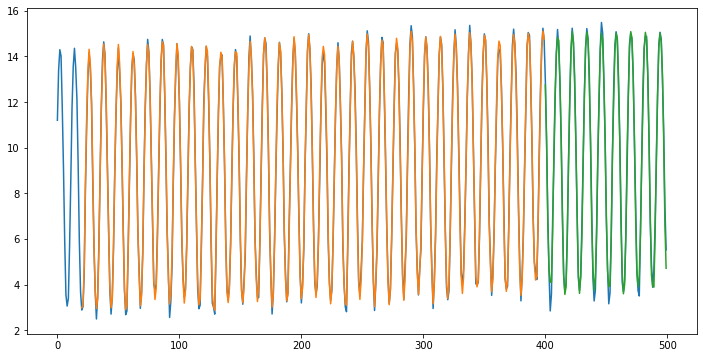

In [212]:
train_size = X_train.shape[0]
test_size = X_test.shape[0]
plt.figure(figsize=(12,6))
plt.plot(series)
plt.plot(np.arange(train_size)+INPUT_LENGTH, trainPredict)
plt.plot(np.arange(train_size, train_size+test_size)+INPUT_LENGTH ,testPredict)
plt.show()

#### TimeseriesGenerator

In [ ]:
X_train, X_test = series[:TRAINING_SIZE], series[TRAINING_SIZE-INPUT_LENGTH:]
train_generator = TimeseriesGenerator(X_train, X_train, length=INPUT_LENGTH, batch_size=X_train.shape[0])
test_generator = TimeseriesGenerator(X_test, X_test, length=INPUT_LENGTH, batch_size=X_test.shape[0])
X_train, y_train = train_generator[0]
X_test, y_test = test_generator[0]

In [219]:
# generator = TimeseriesGenerator(X_train, X_train, length=INPUT_LENGTH, batch_size=X_train.shape[0])
# X_fulltrain, y_fulltrain = train_generator[0]
# X_train, X_test = X_fulltrain[:TRAINING_SIZE-INPUT_LENGTH], X_fulltrain[TRAINING_SIZE-INPUT_LENGTH:]
# y_train, y_test = y_fulltrain[:TRAINING_SIZE-INPUT_LENGTH], X_fulltrain[TRAINING_SIZE-INPUT_LENGTH:]

0.041728194802999496


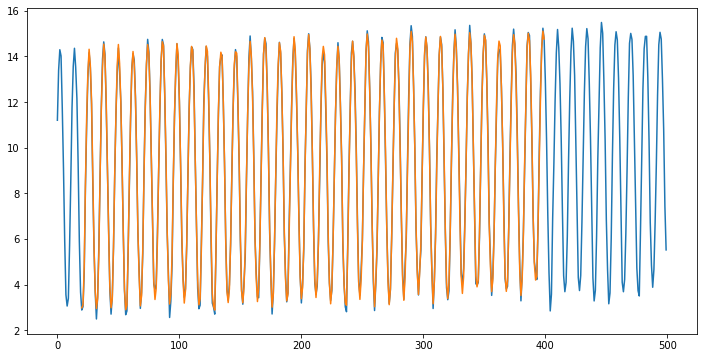

In [220]:
reg = XGBRegressor(seed=42)
reg.fit(X_train, y_train)
testPredict = reg.predict(X_test)
trainPredict = reg.predict(X_train)
print(float(mse(y_train, trainPredict)))

train_size = X_train.shape[0]
test_size = X_test.shape[0]
plt.figure(figsize=(12,6))
plt.plot(series)
plt.plot(np.arange(train_size)+INPUT_LENGTH, trainPredict)
plt.plot(np.arange(train_size, train_size+test_size)+INPUT_LENGTH ,testPredict)
plt.show()

### Conv 1-D

In [82]:
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten

In [97]:
def conv_model(input_length):
    model = Sequential()
    model.add(Conv1D(filters=8, kernel_size=3, activation=LeakyReLU(alpha=0.3), input_shape=(input_length, 1)))
    model.add(Conv1D(filters=8, kernel_size=3, activation=LeakyReLU(alpha=0.3)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation=LeakyReLU(alpha=0.3)))
    model.add(Dense(1))
    return model

0.11197383608669043


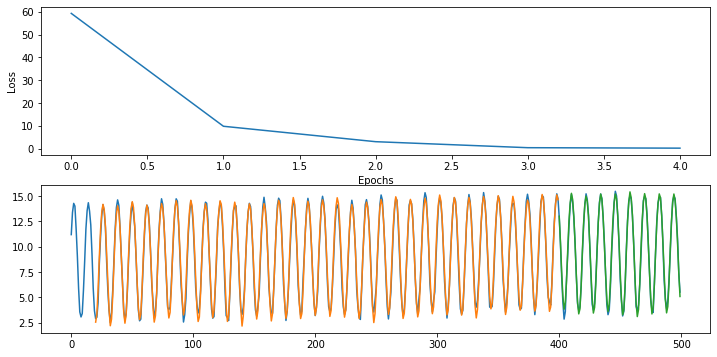

In [98]:
EPOCH = 5
plot_pred(temp['LandAverageTemperature'].values.reshape(-1,1),
          train_size=400, input_length=20, batch_size=5,
          model=conv_model(input_length=20)
         )

In [101]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate

In [178]:
def mixte_model(input_length):
    inputs = Input(shape=(input_length, 1))
    
    conv = Conv1D(filters=8, kernel_size=3, activation=LeakyReLU(alpha=0.3))(inputs)
    conv = Conv1D(filters=8, kernel_size=3, activation=LeakyReLU(alpha=0.3))(conv)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv = Dense(10, activation=LeakyReLU(alpha=0.3))(conv)
    #conv = Dropout(0.5)(conv)
    
    lstm = LSTM(10, activation=LeakyReLU(alpha=0.3))(inputs)
    #lstm = Dropout(0.5)(lstm)
    
    merge = Concatenate()([conv,lstm])
    #merge = Dense(10, activation=LeakyReLU(alpha=0.3))(merge)
    outputs = Dense(1)(merge)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

def stack_model(input_length):
    inputs = Input(shape=(input_length, 1))
    
    conv = Conv1D(filters=8, padding='same', kernel_size=3, activation=LeakyReLU(alpha=0.3))(inputs)
    #conv = Conv1D(filters=8, kernel_size=3, activation=LeakyReLU(alpha=0.3))(conv)
    conv = Dropout(0.2)(conv)
    
    concat = Concatenate()([conv,inputs])
    
    lstm = LSTM(10, activation=LeakyReLU(alpha=0.3))(concat)
    outputs = Dense(1)(lstm)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

0.18861835934221743


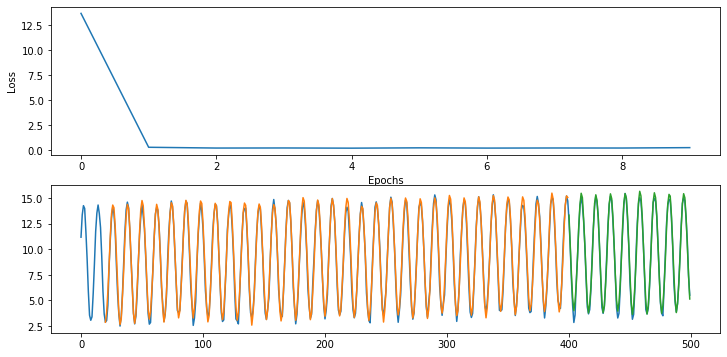

In [138]:
EPOCH = 10
plot_pred(temp['LandAverageTemperature'].values.reshape(-1,1),
          train_size=400, input_length=20, batch_size=5,
          model=mixte_model(input_length=20)
         )

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_70 (Conv1D)              (None, 20, 8)        32          input_39[0][0]                   
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 20, 8)        0           conv1d_70[0][0]                  
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 20, 9)        0           dropout_15[0][0]                 
                                                                 input_39[0][0]            

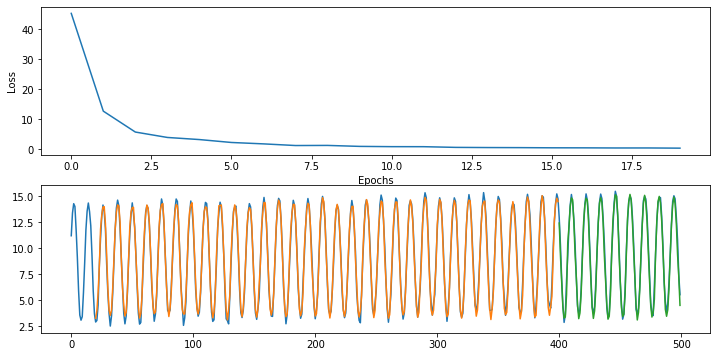

In [179]:
EPOCH = 20
plot_pred(temp['LandAverageTemperature'].values.reshape(-1,1),
          train_size=400, input_length=20, batch_size=5,
          model=stack_model(input_length=20)
         )